# Examen Python Data Developer
# Deel 2

Ga verder met de verwerkte data die je uit deel 1 hebt. We gaan nu op basis van dezelfde dataset een aantal onderzoeksvragen oplossen!

### Importeren van packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

### Inlezen data

In [2]:
loc_input_files = os.path.join('..', 'data', 'input')

dfs = list()
for filename in os.listdir(loc_input_files):
    df = pd.read_csv(os.path.join(loc_input_files,filename))
    df['datum'] = filename.strip('.csv')
    dfs.append(df)

df_raw = pd.concat(dfs, ignore_index=True)
df = df_raw.copy()

### Preprocessing

In [3]:
def clean_df_unisex(df):

    df = df.rename(columns={'verwachte datum': 'verwachte_datum'})

    # verander 2019-02-29 to 2019-02-28
    df.loc[df['datum'] == '2019-2-29', 'datum'] = '2019-2-28'

    df['dag_van_jaar'] = pd.to_datetime(df['datum']).dt.dayofyear
    df['verwachte_datum'] = pd.to_datetime(df['verwachte_datum'])
    df['datum'] = pd.to_datetime(df['datum'])

    return df

In [4]:
def clean_df_datums(df):

    df = df.rename(columns={'verwachte datum': 'verwachte_datum'})

    # df_wrong met verkeerde datum (29 februari)
    outlier_datums = ['2019-2-29','2019-1-1', '2019-7-1']
    df_wrong = df.loc[df['datum'].isin(outlier_datums)].copy()

    # Verwijder rijen met verkeerde datums
    df = df.loc[~df['datum'].isin(outlier_datums)].copy()
    df['dag_van_jaar'] = pd.to_datetime(df['datum']).dt.dayofyear
    df['verwachte_dag_van_jaar'] = pd.to_datetime(df['verwachte_datum']).dt.dayofyear
    df['verwachte_datum'] = pd.to_datetime(df['verwachte_datum'])
    df['datum'] = pd.to_datetime(df['datum'])
    
    df['verschil_dagen'] = (df['datum'] - df['verwachte_datum']).dt.days

    return df, df_wrong

In [5]:
geboortes = clean_df_unisex(df)

In [6]:
geboortes

,gemeente,naam,geslacht,verwachte_datum,datum,dag_van_jaar
0,Hooglede,Elias,Mannelijk,2019-01-14,2019-01-01,1
1,Sint-Niklaas (Sint-Niklaas),Pauline,Vrouwelijk,2019-01-05,2019-01-01,1
2,Wijnegem,Anita,Vrouwelijk,2019-01-05,2019-01-01,1
3,Grâce-Hollogne,Jean-Paul,Mannelijk,2019-01-13,2019-01-01,1
4,Boussu,François,Mannelijk,2019-01-26,2019-01-01,1
...,...,...,...,...,...,...
116918,Lede,Lobke,Vrouwelijk,2019-09-12,2019-09-09,252
116919,Westerlo,Willem,Mannelijk,2019-09-04,2019-09-09,252
116920,Brugge,Diane,Vrouwelijk,2019-09-20,2019-09-09,252
116921,Lendelede,Marie-Rose,Vrouwelijk,2019-10-28,2019-09-09,252


### Onderzoek 1: Unisex namen
#### Een aantal statistieken
Sommige namen zijn unisex, dat wil zeggen dat zij hetzelfde zijn voor mannen en vrouwen. Beantwoord volgende 3 vragen over unisex namen in onze dataset:
 - Hoeveel unisex namen zijn er?
 - Wat is de meest voorkomende unisex naam; hiervoor zoek ik 3 namen (en getallen):
    - De meest populaire unisex naam bij mannen.
    - De meest populaire unisex naam bij vrouwen.
    - De meest popuaire unisex naam.

**Tip:** Neem hiervoor terug de volledige dataset in acht (dus met de foutief geklasseerde namen).

In [19]:
geslacht_groups = df.groupby('naam')['geslacht'].nunique()
unisex_names = geslacht_groups[geslacht_groups > 1].index

def filter_and_group(df, names, gender=None):
    if gender:
        return df[(df['naam'].isin(names)) & (df['geslacht'] == gender)].groupby('naam').size()
    else:
        return df[df['naam'].isin(names)].groupby('naam').size()

df_unisex = filter_and_group(geboortes, unisex_names)
df_unisex_mannelijk = filter_and_group(geboortes, unisex_names, 'Mannelijk')
df_unisex_vrouwelijk = filter_and_group(geboortes, unisex_names, 'Vrouwelijk')

print(f'Populairse unisex naam voor jongens: {df_unisex_mannelijk.idxmax()}') 
print(f'Populairse unisex naam voor meisjes: {df_unisex_vrouwelijk.idxmax()}') 
print(f'Populairse unisex naam in het algemeen: {df_unisex.idxmax()}')

Populairse unisex naam voor jongens: Maxime
Populairse unisex naam voor meisjes: Dominique
Populairse unisex naam in het algemeen: Dominique


We zien dat er een vrij groot aantal namen veel meer voorkomen bij mannen dan vrouwen (en omgekeerd). Dit vinden we eigenlijk geen "echte" unisex namen. We noemen een naam "echt unisex" als de naam niet meer dan 50% meer voorkomt bij 1 van de 2 geslachten. Dus als er `x` mannen en `y` vrouwen zijn genaamd Chris, dan noemen we Chris "echt unisex" als `x <= 1.5 * y` en `y <= x * 1.5`. Filter je unisex dataframe tot een `df_real_unisex` waarbij je enkel de "echte" unisex namen weerhoudt. 
- Beantwoord nu bovenstaande 3 vragen opnieuw voor deze dataset. Hierbij werk je best met een functie zodat je geen code moet herhalen!
- Zijn de echte unisex namen populairder bij mannen of vrouwen, of is de populariteit hetzelfde? Deze vraag kan je beantwoorden door te kijken naar het percentage mannen/vrouwen met een echte unisex naam.

In [17]:
unisex_by_naam_geslacht = (geboortes[geboortes['naam'].isin(unisex_names)]
                                                      .groupby(['naam', 'geslacht'])
                                                      .size())

total_by_naam = (geboortes[geboortes['naam'].isin(unisex_names)]
                                            .groupby('naam')
                                            .size())

percentage_unisex_by_naam_geslacht = (unisex_by_naam_geslacht / total_by_naam) * 100

unisex_df_unstacked = percentage_unisex_by_naam_geslacht.unstack()

df_real_unisex = unisex_df_unstacked[
    (unisex_df_unstacked['Mannelijk'] <= 1.5 * unisex_df_unstacked['Vrouwelijk']) &
    (unisex_df_unstacked['Vrouwelijk'] <= 1.5 * unisex_df_unstacked['Mannelijk'])
]

df_real_unisex = df_real_unisex.reset_index()

In [21]:
real_unisex_namen = df_real_unisex['naam']
genders = {'': real_unisex_namen, 'Mannelijk': real_unisex_namen, 'Vrouwelijk': real_unisex_namen}

df_unisex_correct = ({gender: geboortes[(geboortes['naam'].isin(names)) 
                                        & (geboortes['geslacht'] == gender if gender else True)]
                                        .groupby('naam').size() for gender, names in genders
                                        .items()})

print(f'Populairse unisex naam voor jongens: {df_unisex_correct["Mannelijk"].idxmax()}')
print(f'Populairse unisex naam voor meisjes: {df_unisex_correct["Vrouwelijk"].idxmax()}')
print(f'Populairse unisex naam in het algemeen: {df_unisex_correct[""].idxmax()}')

Populairse unisex naam voor jongens: Dominique
Populairse unisex naam voor meisjes: Dominique
Populairse unisex naam in het algemeen: Dominique


In [20]:
geboortes['unisex'] = geboortes['naam'].isin(real_unisex_namen)

unisex_percentage = geboortes.groupby('geslacht')['unisex'].mean() * 100

print(f'Percentage unisex namen dat mannelijk is: {unisex_percentage["Mannelijk"]:.1f}%')
print(f'Percentage unisex namen dat vrouwelijk is: {unisex_percentage["Vrouwelijk"]:.1f}%')

Percentage unisex namen dat mannelijk is: 0.4%
Percentage unisex namen dat vrouwelijk is: 0.5%


#### Visualizatie

Maak een visualizatie die alle echte unisex namen toont en de relatieve voorkomens bij mannen en vrouwen.

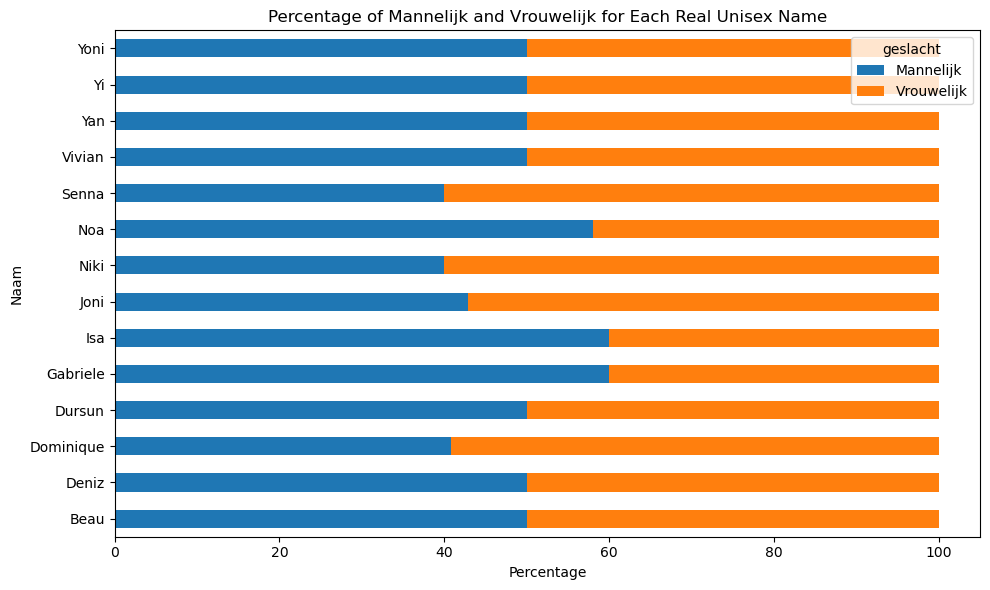

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

df_real_unisex_plot = df_real_unisex.set_index('naam').copy()

df_real_unisex_plot.plot(kind='barh', stacked=True, ax = ax)

plt.title('Percentage of Mannelijk and Vrouwelijk for Each Real Unisex Name')
plt.xlabel('Percentage')
plt.ylabel('Naam')
plt.tight_layout()
plt.show()

### Onderzoek 2: de accuraatheid van de geschatte bevallingsdatum
#### Evolutie vergelijken

Maak een afbeelding van het totaal aantal geboortes per dag en het totaal aantal verwachte geboortes.

**Bonusvraag**: Gewoon om over na te denken: waarom zien de uiteindes van je plot er wat gek uit? Schrijf het antwoord neer in een strategisch geplaatste markdown cel.

In [12]:
geboortes_datums, geboortes_datums_wrong = clean_df_datums(df_raw)
geboortes_datums

,gemeente,naam,geslacht,verwachte_datum,datum,dag_van_jaar,verwachte_dag_van_jaar,verschil_dagen
534,Merksplas,Liliane,Vrouwelijk,2019-01-04,2019-01-10,10,4,6
535,Bornem,Jeroen,Mannelijk,2019-01-10,2019-01-10,10,10,0
536,Houthalen-Helchteren,Fatima,Vrouwelijk,2019-01-21,2019-01-10,10,21,-11
537,Lievegem,Hilaire,Mannelijk,2019-01-15,2019-01-10,10,15,-5
538,Spiere-Helkijn,Christian,Mannelijk,2019-01-16,2019-01-10,10,16,-6
...,...,...,...,...,...,...,...,...
116918,Lede,Lobke,Vrouwelijk,2019-09-12,2019-09-09,252,255,-3
116919,Westerlo,Willem,Mannelijk,2019-09-04,2019-09-09,252,247,5
116920,Brugge,Diane,Vrouwelijk,2019-09-20,2019-09-09,252,263,-11
116921,Lendelede,Marie-Rose,Vrouwelijk,2019-10-28,2019-09-09,252,301,-49


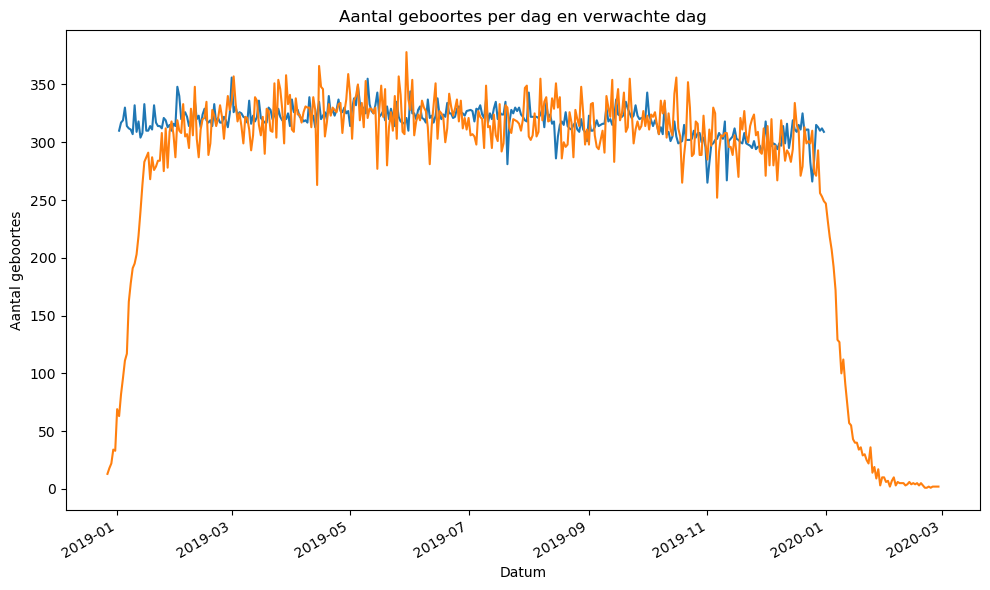

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

geboortes_datums.groupby('datum').size().plot(ax=ax, label='Echte aantal geboortes')
geboortes_datums.groupby('verwachte_datum').size().plot(ax=ax, label='Verwacht aantal geboortes')

ax.set(title='Aantal geboortes per dag en verwachte dag', xlabel='Datum', ylabel='Aantal geboortes')
plt.tight_layout()
plt.show()

### Verklaring uiteindes
Van de echte aantal geboortes hebben we enkel datums binnen 2019, terwijl er voor het verwachte aantal geboortes wel een schatting is gemaakt. Op basis van het histogram voor het verschil in echte en geschatte datums (zie figuur hieronder) zien we dat er tot 60 dagen te vroeg en 6 dagen te laat verwacht kan worden. Dit reflecteert ook in deze grafiek aangezien de verwachte datum tot maximaal 60 dagen na 31 december gaat en tot maximaal 6 dagen voor 1 januari. 

Voorbeeld: Een kind geboren op 31 december 2019 kan verwachte datum 28 februari 2020 gehad hebben en is dus te vroeg geboren.
Voorbeeld: Een kind geboren op 1 january 2019 kan als verwachte datum 25 december 2018 gehad hebben en is dus te laat geboren.

Naargelang er geen echte datums beschikbaar zijn wordt de kans steeds kleiner dat er geboortes zijn op de uiterste verwachte datums.
(Deze uiteindes zijn het gevolg van een gegenereerde dataset.)

#### Verbanden bekijken
Maak een histogram van het aantal dagen dat babies te vroeg geboren werden in 2019 en een scatterplot die het verband toont tussen de verwachte en effectieve geboortedatum.

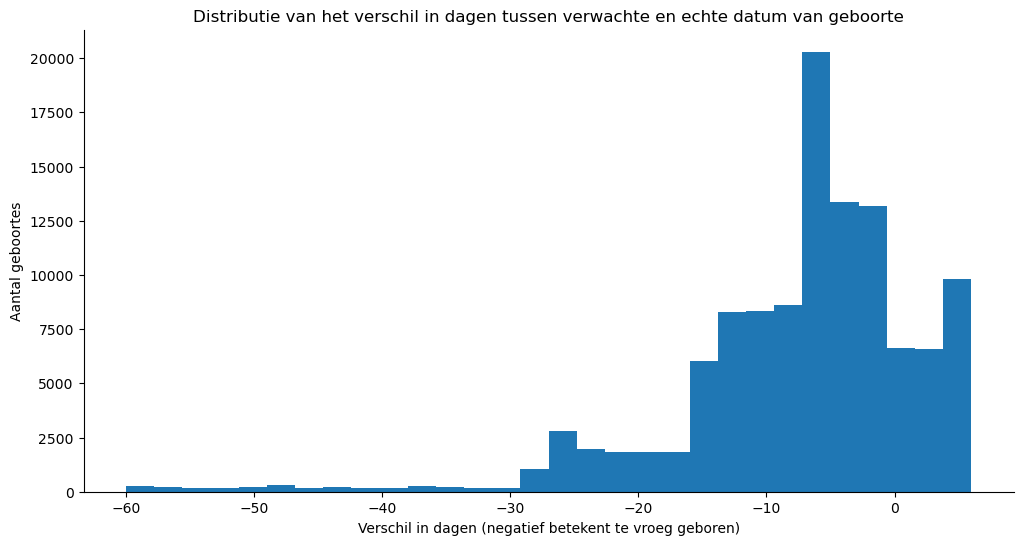

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

geboortes_datums['verschil_dagen'].plot(kind='hist', bins=30, ax=ax)
plt.title('Distributie van het verschil in dagen tussen verwachte en echte datum van geboorte')
plt.xlabel('Verschil in dagen (negatief betekent te vroeg geboren)')
plt.ylabel('Aantal geboortes')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

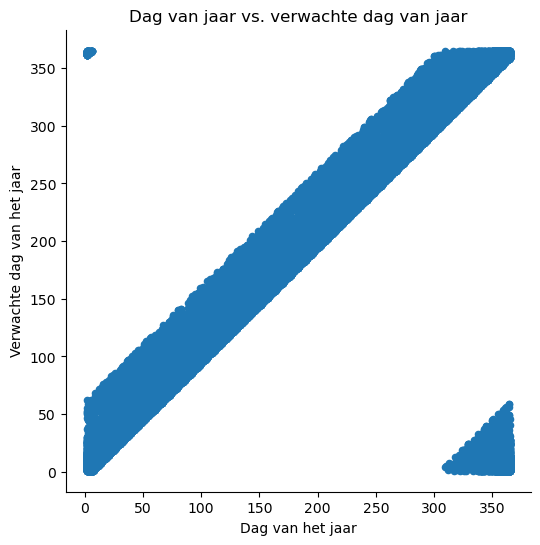

In [15]:
# scatterplot dag van jaar vs. verwachte dag van jaar

fig, ax = plt.subplots(figsize=(6, 6))

geboortes_datums.plot(kind='scatter', x='dag_van_jaar', y='verwachte_dag_van_jaar', ax=ax)
plt.title('Dag van jaar vs. verwachte dag van jaar')
plt.xlabel('Dag van het jaar')
plt.ylabel('Verwachte dag van het jaar')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


### Onderzoek 3: Aantal namen versus aantal babies
Naarmate dat er meer babies geboren worden, gaan deze ook meer verschillende namen krijgen. Zolang er weinig babies geboren worden lijkt het logisch dat dit verband min of meer lineair is, maar naarmate dat er meer en meer babies geboren worden lijkt het niet meer logisch dat dit verband lineair blijft. We verwachten bijvoorbeeld niet dat het aantal unieke namen gegeven aan 2 miljoen babies het dubbel is van het aantal unieke namen gegeven aan 1 miljoen babies. Kan je op basis van deze dataset het verband tussen het aantal unieke namen in functie van het aantal babies eens onderzoeken? Hiervoor krijg je geen voorstel tot visualizatie maar moet je zelf mij proberen te overtuigen van je antwoord.

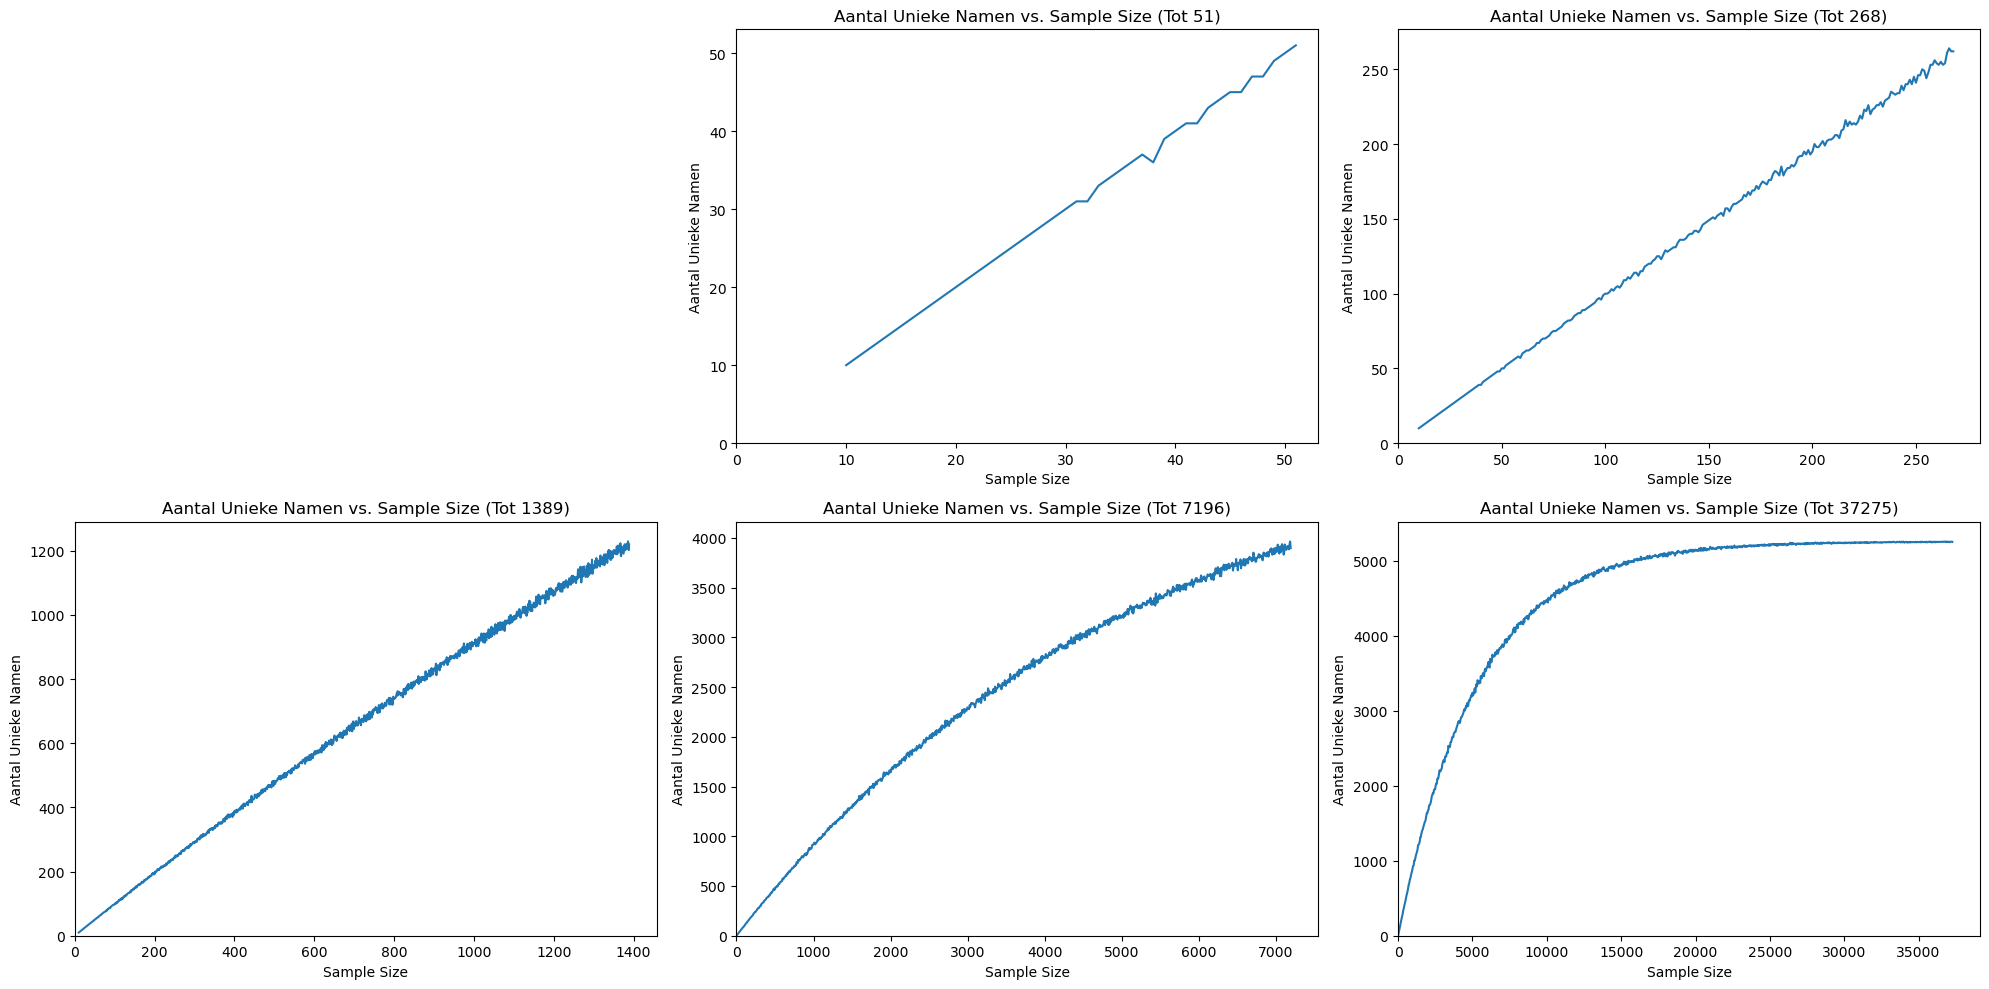

In [16]:
# unieke set van namen
unique_names_list = list(set(geboortes['naam']))

n_simulations = 10000

# Sample size voor elk plot
sample_sizes_parts = sample_sizes_parts = np.logspace(1, 6, 8, dtype=int)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, ax in enumerate(axs.flatten()):
    if i == 0:  # eerst plot is leeg
        ax.set_visible(False)
        continue
    
    results = []
    
    for sample_size in range(10, sample_sizes_parts[i] + 1, max(sample_sizes_parts[i] // 1000, 1)):

        sample = random.choices(unique_names_list, k=sample_size)
        
        n_unique_names = len(set(sample))
        
        results.append(n_unique_names)
    
    ax.plot(range(10, sample_sizes_parts[i] + 1, max(sample_sizes_parts[i] // 1000, 1)), results)
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Aantal Unieke Namen')
    ax.set_title(f'Aantal Unieke Namen vs. Sample Size (Tot {sample_sizes_parts[i]})')

plt.tight_layout()
plt.show()

### Verklaring

Vertrekkende vanuit een lijst namen, ongeacht hoe lang deze is, als je namen moet selecteren kan je maar zoveel unieke namen selecteren als dat er namen bestaan. Zolang je minder namen selecteert dan dat er bestaan, dan is de kans groot dat een naam slechts 1 maal wordt geselecteerd. Dit vertaalt zich dan in een lineair verband. Van zodra de selectie van namen echter toeneemt wordt de kans telkens groter dat eenzelfde naam vaker wordt geselecteerd. Bij een grotere sample size van een zelfde set van namen gaat dit lineair verband dus over in een logaritmisch verband. Je krijgt uiteindelijk een afvlakking bij de hoeveelheid unieke namen dat er oorspronkelijk beschikbaar waren.

In het gesimuleerde model zie je inderdaad dat vertrekkende vanuit een unieke set van namen, bij kleinere sample sizes een lineair verband te zien is. Als we echter de sample size verhogen dan bereiken we een plateau in de hoeveelheid unieke namen dat er voorkomen.

In de simulatie is het aantal beschikbare unieke namen 5000. In het echte leven is deze unieke lijst veel langer, maar hetzelfde principe blijft wel gelden.